# Breakout

In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
import gym
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
def preprocess(image):
    """ prepro 210x160x3 uint8 frame into 6400 (or 80x80) nD float array """
    image = image[35:195] # crop
    image = image[::2,::2,0] # downsample by factor of 2
    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else just set to 1
    return np.reshape(image.astype(np.float).ravel(), 6400)

In [3]:
class DQN:

    def __init__(self, n_actions, n_features):
        
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = 0.01
        self.discount_factor = 0.95
        self.update_params = 200
        self.buffer_size = 2000
        self.batch_size = 32
        self.epsilon = 0.9
        self.step_counter = 0
        self.hidden_size = 20

        self.memory = np.zeros((self.buffer_size, n_features * 2 + 2)) 
        self.build_network()
        target_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target_network')
        evaluate_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='evaluate_network')
        with tf.variable_scope('update_params', reuse=tf.AUTO_REUSE):
            self.target_replace_op = [tf.assign(t, e) for t, e in zip(target_params, evaluate_params)]

        self.sess = tf.Session()

        self.sess.run(tf.global_variables_initializer())
        self.loss_list = []
        self.max_q = []

    def build_network(self):
        self.s = tf.placeholder(tf.float32, [None, self.n_features])  # input State
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features])  # input Next State
        self.r = tf.placeholder(tf.float32, [None, ], name='r')  # input Reward
        self.a = tf.placeholder(tf.int32, [None, ], name='a')  # input Action
        w_init, b_init = tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)
        with tf.variable_scope('evaluate_network', reuse=tf.AUTO_REUSE):
            e1 = tf.layers.dense(self.s, self.hidden_size, tf.nn.relu, kernel_initializer=w_init)
            self.q_eval = tf.layers.dense(e1, self.n_actions, kernel_initializer=w_init, bias_initializer=b_init)
        with tf.variable_scope('target_network', reuse=tf.AUTO_REUSE):
            t1 = tf.layers.dense(self.s_, self.hidden_size, tf.nn.relu, kernel_initializer=w_init)
            self.q_next = tf.layers.dense(t1, self.n_actions, kernel_initializer=w_init, bias_initializer=b_init)
        with tf.variable_scope('q_target', reuse=tf.AUTO_REUSE):
            q_target = self.r + self.discount_factor * tf.reduce_max(self.q_next, axis=1)   
            self.q_target = tf.stop_gradient(q_target)        
        with tf.variable_scope('q_evaluate', reuse=tf.AUTO_REUSE):
            a_indices = tf.stack([tf.range(tf.shape(self.a)[0], dtype=tf.int32), self.a], axis=1)
            self.q_eval_wrt_a = tf.gather_nd(params=self.q_eval, indices=a_indices)   
        with tf.variable_scope('loss', reuse=tf.AUTO_REUSE):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval_wrt_a))
        with tf.variable_scope('train', reuse=tf.AUTO_REUSE):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

    def transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
        t = np.hstack((s, [a, r], s_))
        index = self.memory_counter % self.buffer_size
        self.memory[index, :] = t
        self.memory_counter += 1

    def choose_action(self, state):
        state = state[np.newaxis, :]
        if np.random.uniform() < self.epsilon:
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: state})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action


    def learn(self):
        if self.step_counter % self.update_params == 0:
            self.sess.run(self.target_replace_op)
        if self.memory_counter > self.buffer_size:
            sample_index = np.random.choice(self.buffer_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]
        _, loss, q_n = self.sess.run(
            [self._train_op, self.loss, self.q_eval_wrt_a],
            feed_dict={
                self.s: batch_memory[:, :self.n_features],
                self.a: batch_memory[:, self.n_features],
                self.r: batch_memory[:, self.n_features + 1],
                self.s_: batch_memory[:, -self.n_features:],
            })

        self.loss_list.append(loss)
        self.max_q.append(np.max(q_n))
        self.step_counter += 1

    def plot_loss(self):
        plt.plot(np.arange(len(self.loss_his)), self.loss_his)
        plt.ylabel('Loss')
        plt.xlabel('Training iteration')
        plt.savefig('Breakout_Loss.png',bbox_inches='tight',facecolor="#FFFFFF")
        plt.show()
    
    def plot_max_q(self):
        self.mean_max_q = [q[0]/q[1] for q in list(zip(np.cumsum(self.max_q), range(1,len(self.max_q)+1)))]
        plt.plot(np.arange(len(self.mean_max_q)), self.mean_max_q)
        plt.ylabel('Average of the maximum Q function')
        plt.xlabel('Training iteration')
        plt.savefig('Breakout_Qfunction.png',bbox_inches='tight',facecolor="#FFFFFF")
        plt.show() 
        
    def save_model(self):
        self.ckpts_path = "Breakout_dqn_save.ckpt"
        self.saver = tf.train.Saver()
        self.saver.save(self.sess, self.ckpts_path)

In [4]:
import logging
logging.basicConfig(level=logging.DEBUG)

def train_DQN(episodes):
    step = 0
    for episode in range(episodes):
        state = env.reset()
        while True:
            action = model.choose_action(preprocess(state))
            state_, reward, done, info = env.step(action)
            model.transition(preprocess(state), action, reward, preprocess(state_))
            if (step > 150) and (step % 5 == 0):
                model.learn()
            state = state_
            if done:
                if episode % 10 == 0:
                    logging.info('Episode {}'.format(str(episode)))
                break
            step += 1
    logging.info('**End of Game**')
    env.close()

In [5]:
def play(episodes=1000):
    saver = tf.train.Saver()
    saver.restore(model.sess, model.ckpts_path)
    step = 0
    rewards = []
    for episode in range(episodes):
        total_reward = 0
        state = env.reset()
        while True:
            action = model.choose_action(preprocess(state))
            state_, reward, done, info = env.step(action)
            total_reward += reward
            state = state_
            if done:
                rewards.append(total_reward)
                break
            step += 1
    logging.info('**End of Game**')
    env.close()
    
    plt.plot(np.arange(len(rewards)), rewards)
    plt.ylabel('Total Reward')
    plt.xlabel('Episode')
    plt.savefig('Breakout_1000games.png',bbox_inches='tight',facecolor="#FFFFFF")
    plt.show()  

ore(<Font 'OpenSymbol' (opens___.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Waree' (Waree-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'P052' (P052-BoldItalic.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Samyak Gujarati' (Samyak-Gujarati.ttf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'D050000L' (D050000L.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nimbus Roman' (NimbusRoman-Italic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-BoldItalic.ttf) italic normal 700 condensed>) = 11.535
DEBUG:matplotlib.font_manager:findfont: 

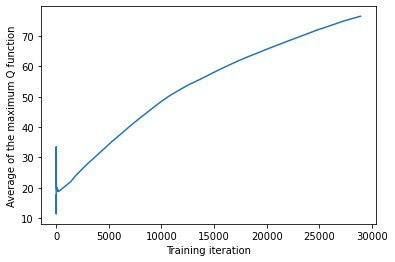

INFO:tensorflow:Restoring parameters from Breakout_dqn_save.ckpt
INFO:tensorflow:Restoring parameters from Breakout_dqn_save.ckpt
INFO:root:**End of Game**


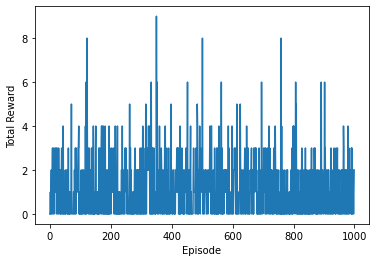

In [6]:
if __name__ == "__main__":
    env = gym.make("Breakout-v0")
    model = DQN(env.action_space.n, 6400)
    train_DQN(episodes=500)
    model.plot_max_q()
    model.save_model()
    play(episodes=1000)